In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target


from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError
from qiskit.result import Result
from qiskit.quantum_info import Statevector

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
h_backend = provider.get_backend("ibmq_lima")

In [10]:
qubit_frequency= 5e9
anharmonicity= -0.25e9
lambda_1= 1e9
lambda_2= 0.8e9



qubit_frequency_02 = 2 * qubit_frequency + anharmonicity
ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

p1 = ket1 @ ket1.T.conj()
p2 = ket2 @ ket2.T.conj()

drift = 2 * np.pi * (qubit_frequency * p1 + qubit_frequency_02 * p2)
control = [
    2
    * np.pi
    * (lambda_1 * (sigma_p1 + sigma_m1) + lambda_2 * (sigma_p2 + sigma_m2))
]
r_frame = 2 * np.pi * qubit_frequency * (p1 + 2 * p2)

In [20]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=r_frame,
    rwa_cutoff_freq=1.9 * qubit_frequency,
    rwa_carrier_freqs=[qubit_frequency],
)

In [24]:
y0 = Statevector([1.0, 0.0, 0.0])
dt = 0.1
area = 0.42
sigma = 5  # ns
amp = area / sigma
sigma = sigma / dt  # ns

duration = np.math.ceil(sigma * 5)
T = duration * dt  # ns

In [ ]:
with pulse.build(backend) as schedule:
    pulse.shift_phase(np.pi, channel)

In [44]:
converter = InstructionToSignals(dt, carriers={"d0": qubit_frequency})
def make_signal(duration, amp, sigma, w, dt=dt):

    with pulse.build(name="spec") as spec:
        shift = w - qubit_frequency
        print(shift)
        pulse.ShiftFrequency(shift, pulse.DriveChannel(0))
        pulse.play(
            pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
            pulse.DriveChannel(0),
        )
        pulse.ShiftFrequency(-shift, pulse.DriveChannel(0))
        
    signals = converter.get_signals(spec)
    return signals  , spec.draw()

500000000.0


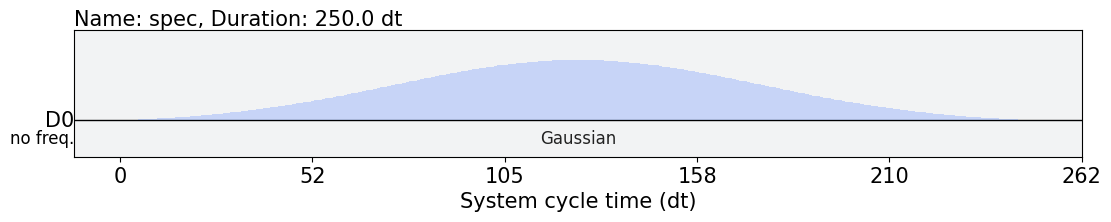

In [45]:
make_signal(duration, amp, sigma, qubit_frequency*1.1, dt=dt)[1]

In [28]:
result = hamiltonian_solver.solve(
    t_span=[0.0, T],
    y0=y0,
    t_eval=[T],
    signals=make_signal(duration, amp, sigma, qubit_frequency, dt=dt),
    method="RK23",
).y[0]

TypeError: play() missing 1 required positional argument: 'channel'